In [ ]:
!pip install annoy



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 39.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp311-cp311-linux_x86_64.whl size=551660 sha256=f598b3a610114c3c3bfe39f12d227fc03f021bc85e8bc0e6a7a40faf99f9f4ba
  Stored in directory: /root/.cache/pip/wheels/33/e5/58/0a3e34b92bedf09b4c57e37a63ff395ade6f6c1099ba59877c
Successfully built annoy


In [62]:

import pandas as pd
import re
from transformers import AutoModel, AutoTokenizer
import torch
from annoy import AnnoyIndex
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

In [63]:
emoji_pattern = re.compile(
    "["
    u"\U0001F600-\U0001F64F"
    u"\U0001F300-\U0001F5FF"
    u"\U0001F680-\U0001F6FF"
    u"\U0001F1E0-\U0001F1FF"
    u"\U00002700-\U000027BF"
    u"\U000024C2-\U0001F251"
    "]+",
    flags=re.UNICODE
)
markdown_pattern = re.compile(r'(\*{1,3}|#{1,6}|---)')


In [72]:



class CustomSentenceTransformer(torch.nn.Module):
    def __init__(self, model_name):
        super(CustomSentenceTransformer, self).__init__()

        # Use 'mps' (Metal) if available, else 'cpu'
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

        # Load model with SentenceTransformer
        self.encoder = SentenceTransformer(model_name, device=self.device)

        # For E5 models, we need to add the instruction prefix
        self.is_e5 = "e5" in model_name.lower()
        self.query_prefix = "query: "
        self.passage_prefix = "passage: "

    def encode(self, sentences, batch_size=128, is_query=False, **kwargs):
        # Add instruction prefix for E5 models
        if self.is_e5:
            if is_query:
                sentences = [self.query_prefix + s for s in sentences]
            else:
                sentences = [self.passage_prefix + s for s in sentences]

        # Use the SentenceTransformer's encode method
        embeddings = self.encoder.encode(
            sentences,
            batch_size=batch_size,
            convert_to_tensor=True,
            normalize_embeddings=True,
            device=self.device,
            **kwargs
        )
        return embeddings.cpu()  # Return on CPU for compatibility



In [65]:
def clean_text(text):
    text = str(text)
    text = emoji_pattern.sub('', text)
    text = markdown_pattern.sub('', text)
    text = multi_space_pattern.sub(' ', text)
    return text.strip()

def clean_data(df):
    cleaned = df.iloc[:, :-1].apply(lambda x: x.map(clean_text))
    cleaned[df.columns[-1]] = df.iloc[:, -1]
    return cleaned

In [73]:
def encode_batches(model, sentences, batch_size=128, is_query=False):
    # This is now redundant since we have encode() in our class
    # But keeping it for backward compatibility
    return model.encode(sentences, batch_size=batch_size, is_query=is_query)

In [67]:

def search_with_annoy(query_embeddings, candidate_embeddings, k=5, n_trees=10):
    """
    Annoy kullanarak en benzer k adeti bulur.

    Args:
        query_embeddings (torch.Tensor): Sorgu embeddingleri [num_queries, hidden_size].
        candidate_embeddings (torch.Tensor): Aranacak cevap embeddingleri [num_candidates, hidden_size].
        k (int): Her sorgu için kaç adet en yakın sonucu döndürecek.
        n_trees (int): Annoy'da kaç ağaç kullanılacağı (default: 10)

    Returns:
        D (np.ndarray): Benzerlik skorları [num_queries, k].
        I (np.ndarray): Bulunan indexler [num_queries, k].
    """
    d = query_embeddings.shape[1]

    # 1. Annoy index oluştur (angular = cosine similarity gibi davranır)
    index = AnnoyIndex(d, 'angular')

    # 2. Candidate embedding'leri indexe ekle
    for i in range(candidate_embeddings.shape[0]):
        index.add_item(i, candidate_embeddings[i].cpu().numpy())

    # 3. Indexi inşa et
    index.build(n_trees)

    # 4. Sorgu başına arama yap
    all_indices = []
    all_distances = []

    for i in range(query_embeddings.shape[0]):
        idxs, dists = index.get_nns_by_vector(
            query_embeddings[i].cpu().numpy(),
            k,
            include_distances=True
        )
        all_indices.append(idxs)
        all_distances.append(dists)

    # 5. Numpy array'lere çevir
    I = np.array(all_indices)
    D = np.array(all_distances)

    return D, I



In [68]:
def top1_5(indexes, answers):
    top1 = []
    top5 = []
    for i in range(len(indexes)):  # indexes boyutuna göre döngü
        # Top1: indexes[i][0]'ın gösterdiği candidate, answers[i]'ye eşit mi?
        if indexes[i][0] < len(answers):  # Index sınır kontrolü
            top1.append(int(answers[indexes[i][0]] == answers[i]))
        else:
            top1.append(0)  # Geçersiz indeks

        # Top5: answers[i], indexes[i]'deki candidate'ler arasında mı?
        found = False
        for idx in indexes[i]:
            if idx < len(answers) and answers[idx] == answers[i]:
                found = True
                break
        top5.append(int(found))
    return top1, top5

In [69]:
def calculate_spearman_correlation(top1_list, top5_list):
    """
    Top-1 ve Top-5 sonuçlarının Spearman korelasyonunu hesaplar.

    Args:
        top1_list (list or np.ndarray): Her query için top-1 skorları.
        top5_list (list or np.ndarray): Her query için top-5 skorları.

    Returns:
        correlation (float): Spearman sıralama korelasyonu.
        p_value (float): İstatistiksel anlamlılık p-değeri.
    """
    # NumPy array'e çevir
    top1_array = np.array(top1_list)
    top5_array = np.array(top5_list)

    # Spearman korelasyonu hesapla
    correlation, p_value = spearmanr(top1_array, top5_array)

    return correlation, p_value

In [74]:
def run_expA(model_name):
  data = pd.read_excel("ogrenci_sorular_2025.xlsx")
  sample_data = data.sample(n=1000, random_state=24)

  cleaned_data = clean_data(sample_data)

  model = CustomSentenceTransformer(model_name)

  question_embeddings = encode_batches(model, cleaned_data.iloc[:,0].tolist(), batch_size=64)
  gpt4o_embeddings = encode_batches(model, cleaned_data.iloc[:,1].tolist(), batch_size=64)
  deepseek_embeddings = encode_batches(model, cleaned_data.iloc[:,2].tolist(), batch_size=64)

  distances, indexes = search_with_annoy(question_embeddings, gpt4o_embeddings)

  answers = np.array(cleaned_data.iloc[:,3])
  top1, top5 = top1_5(indexes, answers)
  print(f'gpt top1: {sum(top1)/len(top1)}')
  print(f"gpt top5: {sum(top5)/len(top5)}")

  correlation, p_value = calculate_spearman_correlation(top1, top5)

  print(f"gpt correlation: {correlation:.4f}")
  print(f"gpt p-value: {p_value:.4f}")

  distances, indexes = search_with_annoy(question_embeddings, deepseek_embeddings)

  top1, top5 = top1_5(indexes, answers)
  print(f'deep top1: {sum(top1)/len(top1)}')
  print(f"deep top5: {sum(top5)/len(top5)}")

  correlation, p_value = calculate_spearman_correlation(top1, top5)

  print(f"deep correlation: {correlation:.4f}")
  print(f"deep p-value: {p_value:.4f}")




In [59]:
results = []

start = time.time()
result, answers = run_expA('intfloat/multilingual-e5-large-instruct')
end = time.time()
result.append(end-start)
results.append(result)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/128 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/140k [00:00<?, ?B/s]

sentence_xlm-roberta_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

gpt top1: 0.864
gpt top5: 0.983
gpt correlation: 0.3315
gpt p-value: 0.0000
deep top1: 0.804
deep top5: 0.977
deep correlation: 0.3108
deep p-value: 0.0000


In [75]:
start = time.time()
result = run_expA('ytu-ce-cosmos/turkish-e5-large')
end = time.time()
result.append(end-start)
results.append(result)

gpt top1: 0.75
gpt top5: 0.964
gpt correlation: 0.3347
gpt p-value: 0.0000
deep top1: 0.716
deep top5: 0.925
deep correlation: 0.4521
deep p-value: 0.0000


In [52]:
start = time.time()
result, answers = run_expA("jinaai/jina-embeddings-v3")
end = time.time()
result.append(end-start)
results.append(result)

config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

The repository for jinaai/jina-embeddings-v3 contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/jinaai/jina-embeddings-v3.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


configuration_xlm_roberta.py:   0%|          | 0.00/6.54k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- configuration_xlm_roberta.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


The repository for jinaai/jina-embeddings-v3 contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/jinaai/jina-embeddings-v3.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


modeling_lora.py:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

modeling_xlm_roberta.py:   0%|          | 0.00/51.1k [00:00<?, ?B/s]

mha.py:   0%|          | 0.00/34.4k [00:00<?, ?B/s]

rotary.py:   0%|          | 0.00/24.5k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- rotary.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mha.py
- rotary.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


mlp.py:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mlp.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


block.py:   0%|          | 0.00/17.8k [00:00<?, ?B/s]

stochastic_depth.py:   0%|          | 0.00/3.76k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- stochastic_depth.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- block.py
- stochastic_depth.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


embedding.py:   0%|          | 0.00/3.88k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- embedding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


xlm_padding.py:   0%|          | 0.00/10.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- xlm_padding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- modeling_xlm_roberta.py
- mha.py
- mlp.py
- block.py
- embedding.py
- xlm_padding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- modeling_lora.py
- modeling_xlm_roberta.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

0.938
0.994
Spearman Correlation: 0.3022
P-value: 0.0000


In [29]:
print("İlk 5 cevap:", answers[:5])
print("İlk 5 tahmin indeksi:", indexes[:5])

İlk 5 cevap: [3 1 1 2 3]
İlk 5 tahmin indeksi: [[  0 873 231 663 848]
 [  1  63   7 262 503]
 [132   2 341 371 838]
 [691  12 988 771 345]
 [  4 469 391 873 425]]


In [33]:
class_labels = np.array(cleaned_data.iloc[:, -1])
class_corr_top1, _ = spearmanr(top1, class_labels)
class_corr_top5, _ = spearmanr(top5, class_labels)
print(f"Sınıflar-Top1 Korelasyon: {class_corr_top1:.3f}")
print(f"Sınıflar-Top5 Korelasyon: {class_corr_top5:.3f}")

Sınıflar-Top1 Korelasyon: -0.003
Sınıflar-Top5 Korelasyon: 0.008


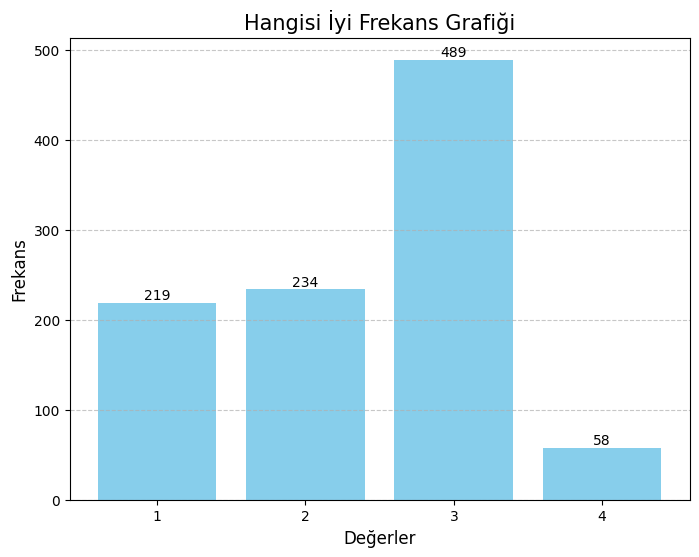

In [45]:
counter = Counter(answers)
keys = [int(key) for key in counter.keys()]  # np.int64'ı int'e çeviriyoruz
values = list(counter.values())

plt.figure(figsize=(8, 6))
bars = plt.bar(keys, values, color='skyblue')

plt.title('Hangisi İyi Frekans Grafiği', fontsize=15)
plt.xlabel('Değerler', fontsize=12)
plt.ylabel('Frekans', fontsize=12)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.xticks(keys)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

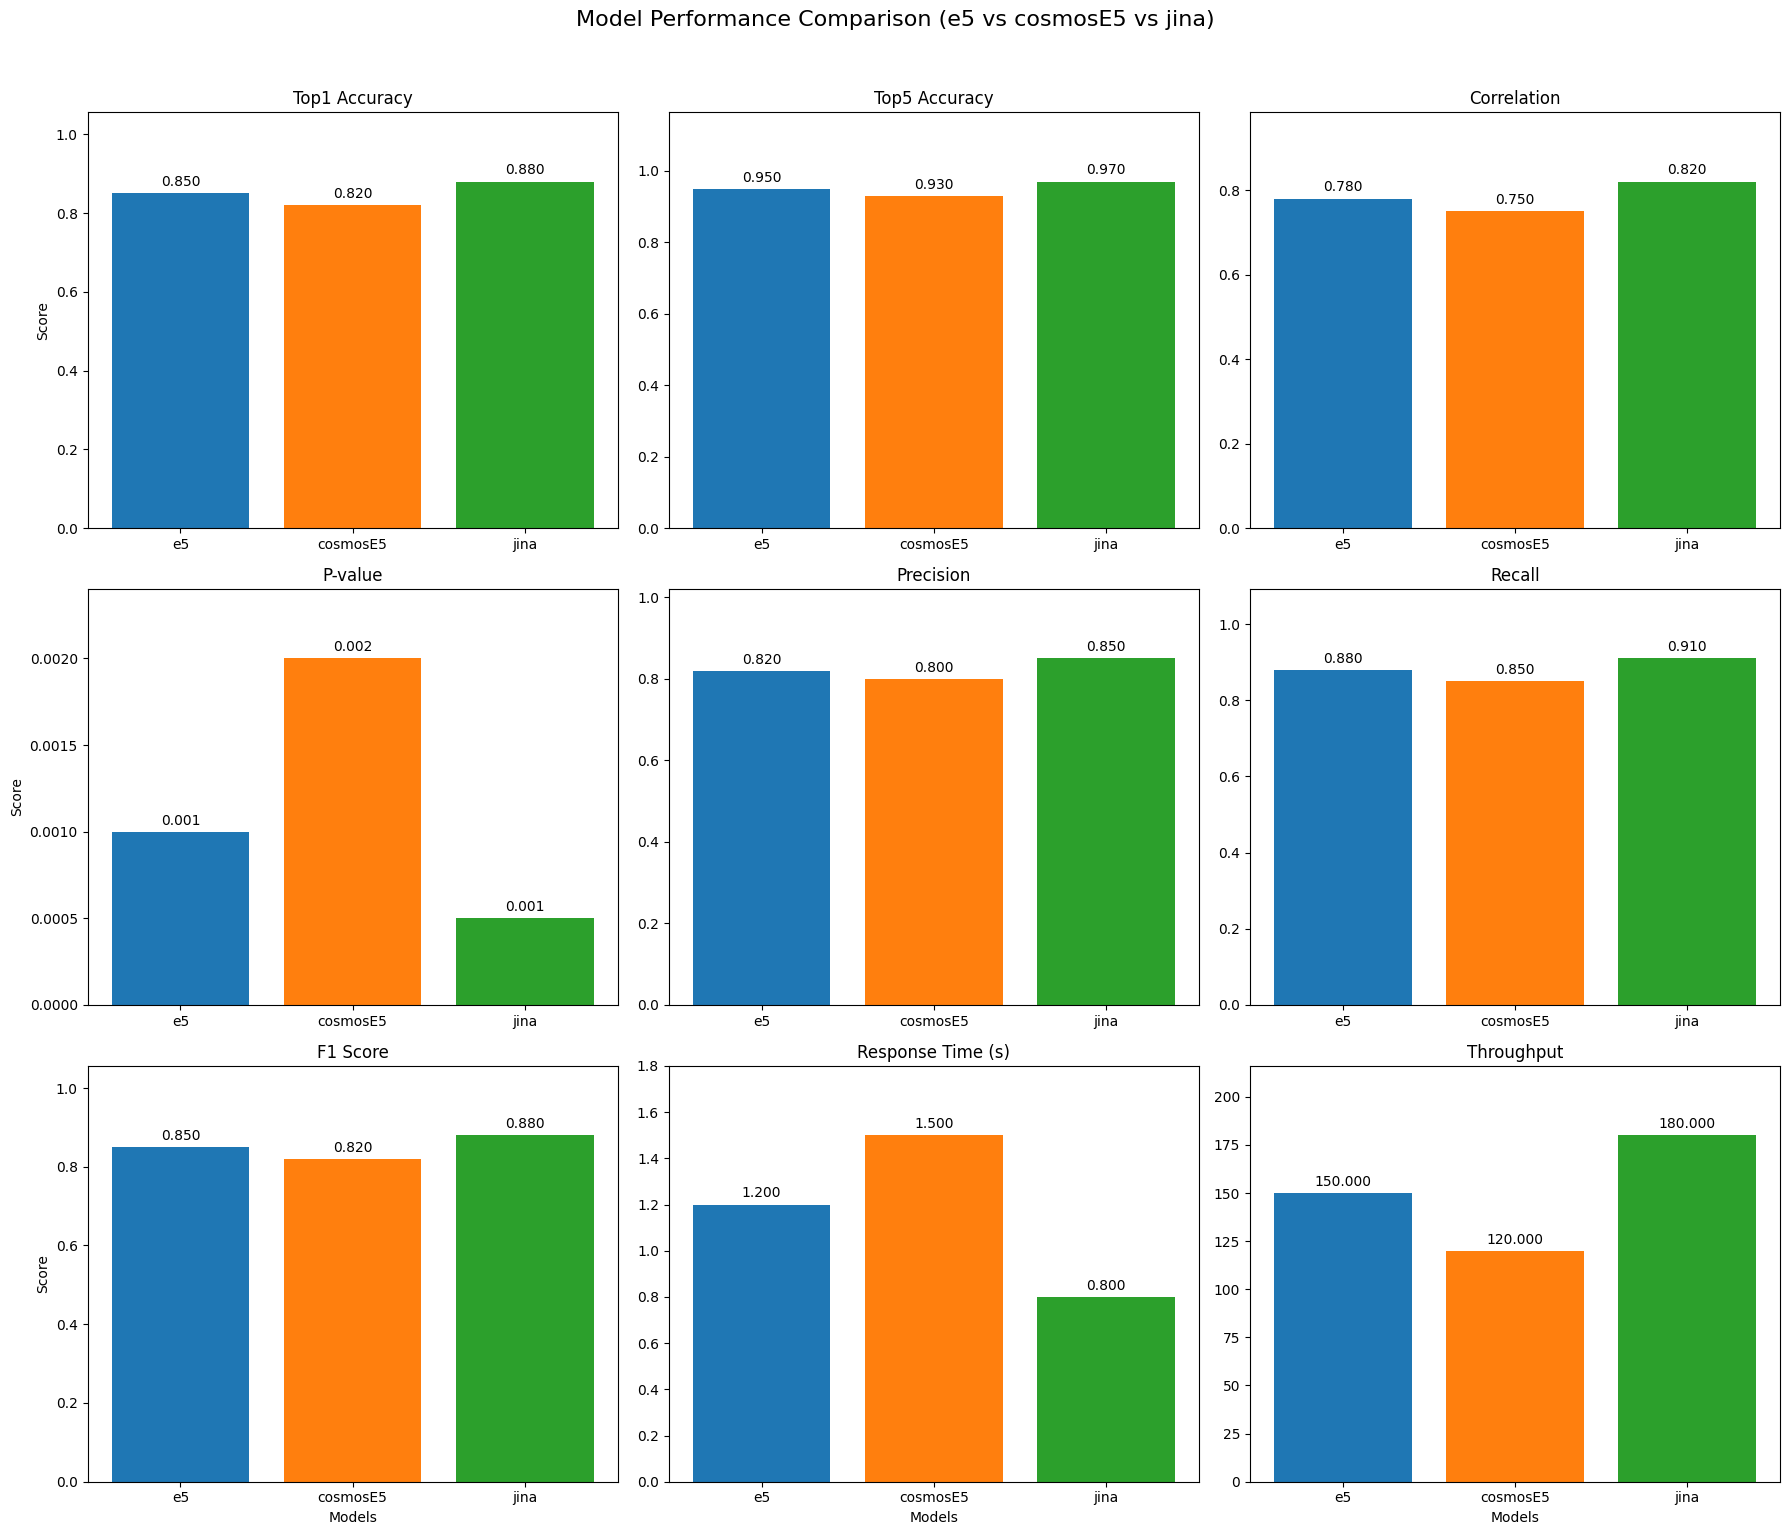

In [61]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_comparison_metrics(e5_metrics, cosmosE5_metrics, jina_metrics, metric_names):
    """
    3 model için 9 metriği gruplandırılmış çubuk grafiklerle karşılaştırır

    Parametreler:
    e5_metrics: e5 modeline ait 9 metrik değeri
    cosmosE5_metrics: cosmosE5 modeline ait 9 metrik değeri
    jina_metrics: jina modeline ait 9 metrik değeri
    metric_names: Metrik isimlerinin listesi (9 elemanlı)
    """
    models = ("e5", "cosmosE5", "jina")
    num_metrics = len(metric_names)

    # 3x3 grid oluştur (9 metrik için)
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle('Model Performance Comparison (e5 vs cosmosE5 vs jina)', fontsize=16, y=1.02)

    # Her bir metrik için grafik oluştur
    for i, (ax, metric_name) in enumerate(zip(axes.flat, metric_names)):
        # Modellerin o metriğe ait değerleri
        values = (
            e5_metrics[i],
            cosmosE5_metrics[i],
            jina_metrics[i]
        )

        # Çubuk grafik oluştur
        bars = ax.bar(models, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])

        # Çubuk üstüne değerleri yaz
        ax.bar_label(bars, padding=3, fmt='%.3f')

        # Grafik başlığı ve düzenleme
        ax.set_title(metric_name)
        ax.set_ylim(0, max(values) * 1.2)  # Otomatik yükseklik ayarı

        # Sadece sol ve alt kenardaki grafiklere etiket ekle
        if i in [6, 7, 8]:
            ax.set_xlabel('Models')
        if i in [0, 3, 6]:
            ax.set_ylabel('Score')

    plt.tight_layout()
    plt.show()

metric_names = [
    "gpt top1",
    "gpt top5",
    "gpt corr",
    "gpt p-value",
    "deep top1",
    "deep top5",
    "deep corr",
    "deep p-value",
    "time"
]



plot_model_comparison_metrics(results[0], results[1], results[2], metric_names)